In [1]:
!pip install boto3

In [2]:
import numpy as np
import pandas as pd
import boto3
from io import BytesIO
import re
import matplotlib.pyplot as plt

# Merge Data Sources

## Open Connection with Amazon S3 Cloud Storage

In [3]:
aws_access_key_id = ''
aws_secret_access_key = ''

bucket_name = ''

# Create an S3 client
s3 = boto3.client('s3', aws_access_key_id=aws_access_key_id, aws_secret_access_key=aws_secret_access_key)

## Helper Functions

In [4]:
def remove_emoji_andN(input_string):
    result = str(input_string).replace('\n', ' ')
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"
                           u"\U0001F300-\U0001F5FF"
                           u"\U0001F680-\U0001F6FF"
                           u"\U0001F700-\U0001F77F"
                           u"\U0001F780-\U0001F7FF"
                           u"\U0001F800-\U0001F8FF"
                           u"\U0001F900-\U0001F9FF"
                           u"\U0001FA00-\U0001FA6F"
                           u"\U0001FA70-\U0001FAFF"
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', result)

def count_skill_keywords(text, keyword_set1, keyword_set2):
    text_1 = re.sub(r'[^a-zA-Z\s]', '', text).lower().split() #for single word
    text_2 = re.sub(r'[^a-zA-Z\s]', '', text).lower() #for word combinations

    #for single word
    matching_words = set(text_1) & keyword_set1
    count_matching_words = len(matching_words)

    #for word combinations
    keyword_pattern = re.compile('|'.join(re.escape(keyword) for keyword in keyword_set2))
    matches = keyword_pattern.findall(text_2)

    return len(set(matches)) + count_matching_words

CS_keywords = set(['python', 'pytorch', 'sql', 'mxnet', 'mlflow', 'einstein', 'theano', 'pyspark', 'solr', 'mahout',
 'cassandra', 'aws', 'powerpoint', 'spark', 'pig', 'sas', 'java', 'nosql', 'docker', 'salesforce', 'scala', 'r',
 'c', 'c++', 'net', 'tableau', 'pandas', 'scikitlearn', 'sklearn', 'matlab', 'scala', 'keras', 'tensorflow', 'clojure',
 'caffe', 'scipy', 'numpy', 'matplotlib', 'vba', 'spss', 'linux', 'azure', 'cloud', 'gcp', 'mongodb', 'mysql', 'oracle',
 'redshift', 'snowflake', 'kafka', 'javascript', 'qlik', 'jupyter', 'perl', 'bigquery', 'unix', 'react',
 'scikit', 'powerbi', 's3', 'ec2', 'lambda', 'ssrs', 'kubernetes', 'hana', 'spacy', 'tf', 'django', 'sagemaker',
 'seaborn', 'mllib', 'github', 'git', 'elasticsearch', 'splunk', 'airflow', 'looker', 'rapidminer', 'birt', 'pentaho',
'jquery', 'nodejs', 'd3', 'plotly', 'bokeh', 'xgboost', 'rstudio', 'shiny', 'dash', 'h20', 'h2o', 'hadoop', 'mapreduce',
 'hive', 'cognos', 'angular', 'nltk', 'flask', 'node', 'firebase', 'bigtable', 'rust', 'php', 'cntk', 'lightgbm',
 'kubeflow', 'rpython', 'unixlinux', 'postgressql', 'postgresql', 'postgres', 'hbase', 'dask', 'ruby', 'julia', 'tensor',
 'dplyr','ggplot2','esquisse','bioconductor','shiny','lubridate','knitr','mlr','quanteda','dt','rcrawler','caret','rmarkdown',
 'leaflet','janitor','ggvis','plotly','rcharts','rbokeh','broom','stringr','magrittr','slidify','rvest',
 'rmysql','rsqlite','prophet','glmnet','text2vec','snowballc','quantmod','rstan','swirl','datasciencer', 'cleansing', 'chatbot', 'cleaning', 'blockchain', 'causality', 'correlation', 'bandit', 'anomaly', 'kpi',
 'dashboard', 'geospatial', 'ocr',  'pca', 'gis', 'svm', 'svd', 'tuning', 'hyperparameter', 'hypothesis',
 'salesforcecom', 'segmentation', 'biostatistics', 'unsupervised', 'supervised', 'exploratory',
 'recommender', 'recommendations', 'research', 'sequencing', 'probability', 'reinforcement', 'graph', 'bioinformatics',
  'knn', 'etl', 'normalization', 'classification', 'optimizing', 'prediction', 'forecasting',
 'clustering', 'optimization', 'visualization', 'nlp', 'c#',
 'regression', 'logistic', 'cnn', 'glm','rnn', 'lstm', 'gbm', 'boosting', 'recurrent', 'convolutional', 'bayesian',
 'bayes'])

group_CS_keywords = set(['amazon web services', 'google cloud', 'sql server', 'random forest', 'natural language processing', 'machine learning', 'decision tree', 'deep learning', 'experimental design',
 'time series', 'nearest neighbors', 'neural network', 'support vector machine', 'computer vision', 'machine vision', 'dimensionality reduction',
 'text analytics', 'power bi', 'a/b testing', 'ab testing', 'chat bot', 'data mining'])

## Jobspikr Dataset

In [5]:
# Specify the file key for the CSV file in AWS S3
file_key = 'data_scientist_united_states_job_postings_jobspikr.csv'

# Retrieve the object from S3 bucket using the specified file key
obj = s3.get_object(Bucket=bucket_name, Key=file_key)

# Read the content of the object
content = obj['Body'].read()

# Create a Pandas DataFrame from the CSV content
Jobspikr = pd.read_csv(BytesIO(content), engine='python')

# Drop rows with missing values in specified columns
Jobspikr = Jobspikr.dropna(subset=['salary_offered', 'city', 'state'])

# Filter by job type to include only 'Full Time' positions
Jobspikr = Jobspikr[Jobspikr['job_type'] == 'Full Time']

# Select relevant columns for further analysis
Jobspikr = Jobspikr[['job_title', 'job_description', 'company_name', 'city', 'state', 'post_date', 'salary_offered']]

# Define a regular expression pattern for extracting salary information
salary_pattern = r'\$([\d,]+)[Kk]?\s*-\s*\$([\d,]+)[Kk]?'

# Function to extract and preprocess salary information from a string
def process_salary_string(salary_str):
    # Extract salary information using the defined pattern
    match = re.search(salary_pattern, salary_str)
    if match:
        lower_salary, upper_salary = map(lambda x: float(x.replace(',', '')), match.groups())
    else:
        # If the pattern does not match, extract numeric values using a different approach
        numeric_values = [float(val.replace(',', '')) for val in re.findall(r'\b[\d,]+\b', salary_str)][:2]
        lower_salary, upper_salary = numeric_values if len(numeric_values) == 2 else (None, None)
    return lower_salary, upper_salary

# Apply the salary extraction function to the 'salary_offered' column
Jobspikr['lower_salary'], Jobspikr['upper_salary'] = zip(*Jobspikr['salary_offered'].map(process_salary_string))

# Create a new column 'approximated_salary' by taking the mean of lower and upper salary values
Jobspikr['approximated_salary'] = Jobspikr[['lower_salary', 'upper_salary']].mean(axis=1).apply(lambda x: int(str(x).split('.')[0][:3]) if pd.notna(x) else x)

# Drop unnecessary columns related to salary
Jobspikr = Jobspikr.drop(columns=['salary_offered', 'lower_salary', 'upper_salary'])

# Drop rows with missing values in the new 'approximated_salary' column
Jobspikr = Jobspikr.dropna(subset=['approximated_salary'])

# Convert 'post_date' to datetime format for further analysis
Jobspikr['post_date'] = pd.to_datetime(Jobspikr['post_date'])

# Extract year, month, and day from 'post_date' into separate columns
Jobspikr[['year', 'month', 'day']] = Jobspikr['post_date'].apply(lambda x: pd.Series([x.year, x.month, x.day]))

# Drop the original 'post_date' column
Jobspikr = Jobspikr.drop(columns=['post_date'])

# Rename columns for clarity and consistency
Jobspikr = Jobspikr.rename(columns={
    'job_title': 'Title',
    'job_description': 'Description',
    'company_name': 'Company Name',
    'city': 'City',
    'state': 'State',
    'year': 'Year',
    'month': 'Month',
    'day': 'Day',
    'approximated_salary': 'Salary'
}).reset_index(drop=True)

# Round and adjust the 'Salary' column to represent salaries in thousands
Jobspikr['Salary'] = (Jobspikr['Salary'] * 1000).round()

# Combine 'Title' and 'Description' columns into a new 'description' column
# This will be useful later
Jobspikr['description'] = Jobspikr['Title'] + ' ' + Jobspikr['Description']
Jobspikr = Jobspikr.drop(['Description'], axis=1)

# Remove emojis and newline characters from the 'description' column
Jobspikr['description'] = Jobspikr['description'].map(remove_emoji_andN)

# Count skill and tool keywords in the 'description' column and create new columns for them
Jobspikr['CS_keywords'] = Jobspikr.apply(lambda row: count_skill_keywords(row['description'], CS_keywords, group_CS_keywords), axis=1)

# Select and order the final columns for the DataFrame
Jobspikr = Jobspikr[['Title', 'description', 'Company Name', 'City', 'State', 'Salary', 'Year', 'Month', 'Day', 'CS_keywords']]

# Rename the 'description' column for consistency
fix_description_column_name= {
    'description': 'Description',
}
Jobspikr = Jobspikr.rename(columns=fix_description_column_name)


In [6]:
Jobspikr.head(3)

,Title,Description,Company Name,City,State,Salary,Year,Month,Day,CS_keywords
0,Data Scientist - Cross Asset Desk Strategist T...,Data Scientist - Cross Asset Desk Strategist T...,Morgan Stanley,New York,NY,90000,2019,8,20,2
1,Senior Data Scientist - Infectious Disease and...,Senior Data Scientist - Infectious Disease and...,Carolinas HealthCare System,Charlotte,NC,125000,2019,9,6,5
2,"Senior Data Scientist, Advanced Marketing Anal...","Senior Data Scientist, Advanced Marketing Anal...",Spotify,New York,NY,125000,2019,8,23,11


## Glassdoor Dataset

In [7]:
file_key = 'Data_Science_Job_Posting_on_Glassdoor.csv'
obj = s3.get_object(Bucket=bucket_name, Key=file_key)
content = obj['Body'].read()
Glassdoor = pd.read_csv(BytesIO(content), engine='python')

# Drop rows with missing values in specified columns
Glassdoor = Glassdoor.dropna(subset=['Salary Estimate', 'Location', 'Company Name'])

# Define a regular expression pattern for salary extraction
salary_pattern = r'\$([\d,]+)[Kk]?\s*-\s*\$([\d,]+)[Kk]?'

# Extract and preprocess salaries
def process_salary_string(salary_str):
    match = re.search(salary_pattern, salary_str)
    if match:
        lower_salary, upper_salary = map(lambda x: float(x.replace(',', '')), match.groups())
    else:
        numeric_values = [float(val.replace(',', '')) for val in re.findall(r'\b[\d,]+\b', salary_str)][:2]
        lower_salary, upper_salary = numeric_values if len(numeric_values) == 2 else (None, None)
    return lower_salary, upper_salary

# Apply the function to extract and preprocess salaries
Glassdoor['lower_salary'], Glassdoor['upper_salary'] = zip(*Glassdoor['Salary Estimate'].map(process_salary_string))

# Create a new column 'approximated_salary'
Glassdoor['approximated_salary'] = Glassdoor[['lower_salary', 'upper_salary']].mean(axis=1).apply(lambda x: int(str(x).split('.')[0][:3]) if pd.notna(x) else x)

# Drop unnecessary columns
Glassdoor = Glassdoor.drop(columns=['Salary Estimate', 'lower_salary', 'upper_salary'])

# Drop rows with missing values in the new column
Glassdoor = Glassdoor.dropna(subset=['approximated_salary'])

# Reset the index to have consecutive indices
Glassdoor = Glassdoor.reset_index(drop=True)

# Select relevant columns
Glassdoor = Glassdoor[['Job Title', 'Job Description', 'Company Name', 'Location','approximated_salary']]

# Split 'Location' into 'City' and 'State' columns
location_split = Glassdoor['Location'].str.split(', ', expand=True)
Glassdoor['City'] = location_split[0]
Glassdoor['State'] = location_split[1]
Glassdoor = Glassdoor.dropna(subset=['State'])

# Drop the original 'Location' column
Glassdoor = Glassdoor.drop(columns=['Location'])

# Rename columns
Glassdoor = Glassdoor.rename(columns={
    'Job Title': 'Title',
    'Job Description': 'Description',
    'city': 'City',
    'state': 'State',
    'year': 'Year',
    'approximated_salary': 'Salary'
}).reset_index(drop=True)

# Add columns filled with NaN
Glassdoor['Year'] = np.nan
Glassdoor['Month'] = np.nan
Glassdoor['Day'] = np.nan

# Convert columns to Int64 type
Glassdoor['Year'] = Glassdoor['Year'].astype('Int64')
Glassdoor['Month'] = Glassdoor['Month'].astype('Int64')
Glassdoor['Day'] = Glassdoor['Day'].astype('Int64')
Glassdoor['Salary'] = Glassdoor['Salary'].astype('Int64')

# Reorder columns to match the specified order
column_order = ['Title', 'Description', 'Company Name', 'City', 'State', 'Salary', 'Year', 'Month', 'Day']
Glassdoor = Glassdoor[column_order]
Glassdoor['Salary'] = Glassdoor['Salary'].apply(lambda x: x*1000)

Glassdoor['description'] = Glassdoor['Title'] + ' ' + Glassdoor['Description']
Glassdoor = Glassdoor.drop(['Description'], axis=1)

Glassdoor['Company Name'] = Glassdoor['Company Name'].map(lambda x: x.split('\n')[0])

Glassdoor['description'] = Glassdoor['description'].map(remove_emoji_andN)

Glassdoor['CS_keywords'] = Glassdoor.apply(lambda row: count_skill_keywords(row['description'], CS_keywords, group_CS_keywords), axis=1)

Glassdoor = Glassdoor[['Title', 'description', 'Company Name', 'City', 'State', 'Salary', 'Year', 'Month', 'Day', 'CS_keywords']]
fix_description_column_name= {
    'description': 'Description',
}
Glassdoor = Glassdoor.rename(columns=fix_description_column_name)


In [8]:
Glassdoor.head(3)

,Title,Description,Company Name,City,State,Salary,Year,Month,Day,CS_keywords
0,Sr Data Scientist,Sr Data Scientist Description The Senior Data...,Healthfirst,New York,NY,154000,<NA>,<NA>,<NA>,10
1,Data Scientist,"Data Scientist Secure our Nation, Ignite your ...",ManTech,Chantilly,VA,154000,<NA>,<NA>,<NA>,8
2,Data Scientist,Data Scientist Overview Analysis Group is on...,Analysis Group,Boston,MA,154000,<NA>,<NA>,<NA>,13


## Indeed Dataset

In [9]:
file_key = 'final_ai_jobs.csv'
obj = s3.get_object(Bucket=bucket_name, Key=file_key)
content = obj['Body'].read()
AI_jobs = pd.read_csv(BytesIO(content), engine='python')

# Drop rows with missing values in specified columns
AI_jobs = AI_jobs[['job_title', 'job_description', 'company_name', 'company_location', 'salary']]

# Split 'Location' into 'City' and 'State' columns
location_split = AI_jobs['company_location'].str.split(', ', expand=True)
AI_jobs['City'] = location_split[0]
AI_jobs['State'] = location_split[1]
AI_jobs = AI_jobs.dropna(subset=['State'])

# Drop the original 'Location' column
AI_jobs = AI_jobs.drop(columns=['company_location'])

#AI_jobs = AI_jobs['salary'] / 100000

# Rename columns
AI_jobs = AI_jobs.rename(columns={
    'job_title': 'Title',
    'job_description': 'Description',
    'company_name': 'Company Name',
    'salary': 'Salary'
}).reset_index(drop=True)

# Add columns filled with NaN
AI_jobs['Year'] = np.nan
AI_jobs['Month'] = np.nan
AI_jobs['Day'] = np.nan

# Remove rows where the salary is 'Not available'
AI_jobs = AI_jobs[AI_jobs['Salary'] != 'Not available']


# Convert columns to Int64 type
AI_jobs['Year'] = AI_jobs['Year'].astype('Int64')
AI_jobs['Month'] = AI_jobs['Month'].astype('Int64')
AI_jobs['Day'] = AI_jobs['Day'].astype('Int64')
AI_jobs['Salary'] = AI_jobs['Salary'].astype('float32').fillna(0).astype('int64')

AI_jobs['description'] = AI_jobs['Title'] + ' ' + AI_jobs['Description']
AI_jobs = AI_jobs.drop(['Description'], axis=1)

AI_jobs['description'] = AI_jobs['description'].map(remove_emoji_andN)

AI_jobs['CS_keywords'] = AI_jobs.apply(lambda row: count_skill_keywords(row['description'], CS_keywords, group_CS_keywords), axis=1)

AI_jobs = AI_jobs[['Title', 'description', 'Company Name', 'City', 'State', 'Salary', 'Year', 'Month', 'Day', 'CS_keywords']]
fix_description_column_name= {
    'description': 'Description',
}

AI_jobs = AI_jobs.rename(columns=fix_description_column_name)

In [10]:
AI_jobs.head(3)

,Title,Description,Company Name,City,State,Salary,Year,Month,Day,CS_keywords
0,"UX Researcher, Qualitative - Generative AI","UX Researcher, Qualitative - Generative AI Wor...",Meta,New York,NY,184500,<NA>,<NA>,<NA>,1
1,Fundamental Language Research Scientist - Gene...,Fundamental Language Research Scientist - Gene...,Meta,New York,NY,173500,<NA>,<NA>,<NA>,2
2,"Data Scientist, Product - Generative AI","Data Scientist, Product - Generative AI You wi...",Facebook App,New York,NY,164000,<NA>,<NA>,<NA>,1


## LinkedIn Dataset

In [11]:
file_key = 'LinkedIn Job Postings.csv'
obj = s3.get_object(Bucket=bucket_name, Key=file_key)
content = obj['Body'].read()
LinkedIn  = pd.read_csv(BytesIO(content), engine='python')

file_key = 'LinkedIn Job Postings_companies.csv'
obj = s3.get_object(Bucket=bucket_name, Key=file_key)
content = obj['Body'].read()
company_id  = pd.read_csv(BytesIO(content), engine='python')

LinkedIn = pd.merge(LinkedIn , company_id, on='company_id', how='inner')

# Filter by job type
LinkedIn = LinkedIn[LinkedIn['formatted_work_type'] == 'Full-time']
LinkedIn = LinkedIn[LinkedIn['work_type'] == 'FULL_TIME']

def convert_to_yearly(row):
    if row['pay_period'] == 'MONTHLY':
        return row['med_salary'] * 12
    elif row['pay_period'] == 'HOURLY':
        # Assuming 40 hours per week and 52 weeks per year
        return row['med_salary'] * 40 * 52
    else:
        return row['med_salary']

# Use the conversion function to create a new 'med_salary' column
LinkedIn['med_salary'] = LinkedIn.apply(convert_to_yearly, axis=1)

LinkedIn = LinkedIn[['title', 'description_x', 'description_y', 'name', 'city', 'min_salary', 'med_salary', 'max_salary', 'state', 'original_listed_time']]
            
LinkedIn['description'] = LinkedIn['description_x'] + ' ' +LinkedIn['description_y'] + ' ' + LinkedIn['title']

LinkedIn = LinkedIn.drop(['description_y', 'description_x'], axis=1)

LinkedIn['description'] = LinkedIn['description'].map(remove_emoji_andN)

LinkedIn['CS_keywords'] = LinkedIn.apply(lambda row: count_skill_keywords(row['description'], CS_keywords, group_CS_keywords), axis=1)

LinkedIn = LinkedIn[['title','description', 'name', 'city','state' ,'min_salary', 'med_salary', 'max_salary', 'original_listed_time','CS_keywords']]

fix_description_column_name = {
    'title': 'Title',
    'description': 'Description',
    'name': 'Company Name',
    'city': 'City',
    'state': 'State',
    'med_salary': 'Salary'
}

LinkedIn = LinkedIn.rename(columns=fix_description_column_name)

LinkedIn = LinkedIn.drop(['min_salary', 'max_salary', 'original_listed_time'], axis=1)

# Add new Year, Month, and Day columns
LinkedIn['Year'] = np.nan  
LinkedIn['Month'] = np.nan  
LinkedIn['Day'] = np.nan  

# Reorder columns
LinkedIn = LinkedIn[['Title', 'Description', 'Company Name', 'City', 'State', 'Salary','Year', 'Month', 'Day', 'CS_keywords']]

# Drop rows that has either null, zero or empty in specified columns
LinkedIn = LinkedIn.dropna(subset=['Description', 'Salary', 'City', 'State'])
LinkedIn = LinkedIn[(LinkedIn['Description'] != '') & (LinkedIn['Salary'] != 0) & (LinkedIn['City'] != '')  & (LinkedIn['City'] != '0') &  (LinkedIn['State'] != '') & (LinkedIn['State'] != '0')]

LinkedIn['Salary'] = LinkedIn['Salary'].astype('float32').fillna(0).astype('int64')

# Save the modified DataFrame to a new CSV file
LinkedIn.to_csv('cleaned_LinkedIn.csv', index=False)

#Keep only job posts related to CS (at least 4 keywords)
LinkedIn = LinkedIn[LinkedIn["CS_keywords"] > 3]


In [12]:
len(LinkedIn)

42

In [13]:
LinkedIn

,Title,Description,Company Name,City,State,Salary,Year,Month,Day,CS_keywords
1593,"Senior Communications Manager, Texas McCombs",Job Posting Title: Senior Communications Mana...,The University of Texas at Austin,Austin,tx,80000,NaN,NaN,NaN,4
1812,Front End Web Developer,About Boomi And What Makes Us Special Are you...,Boomi,Chesterbrook,PA,82366,NaN,NaN,NaN,4
2236,Python Developer,ECS is seeking a Python Developer for our USP...,ECS,Fairfax,VA,85000,NaN,NaN,NaN,12
4589,Data Engineer USA citizenship required REMOTE,Required United States Citizenship • Hands On ...,TechPerm Incorporated,Annapolis,Maryland,125000,NaN,NaN,NaN,6
5787,Budget Analyst,Job Position:- Budget Analyst Client Name:- S...,iAppsData Inc.,Jersey City,New Jersey,104000,NaN,NaN,NaN,5
6824,Azure/Databricks Data Engineer - Empower (remo...,Company Description Company Overview Hitachi...,Hitachi Solutions America,Irvine,CA,175000,NaN,NaN,NaN,11
8629,ERP Systems Administrator,About Senox:Senox Corporation is a leading man...,Senox Corporation,Austin,TX,104650,NaN,NaN,NaN,6
10260,Systems Developer,Job Name: OR - Systems Developer 3 Facility A...,TriOptus,Clarksburg,Maryland,108160,NaN,NaN,NaN,7
10333,Security and Systems Manager,"Location: 13001 Starkey Road, Largo, FL 33773 ...",Pinellas County Government,Clearwater,Florida,80000,NaN,NaN,NaN,4
11414,Senior Director of Technology,Description 7+ years out of university with 5...,Resolute Consulting Group,Houston,Texas,200000,NaN,NaN,NaN,5


## Merge the Datasets

In [14]:
big_merged_df = pd.concat([Jobspikr, Glassdoor, AI_jobs, LinkedIn], ignore_index=True, join='outer')

# Calculate the average of the 'Year' column
average_year = big_merged_df['Year'].mean()
average_Month = big_merged_df['Month'].mean()
average_day = big_merged_df['Day'].mean()

# Print the average year
print("Average Year:", average_year)
print("Average Month:", average_Month)
print("Average Day:", average_day)

# Round the average_year and convert it to an integer
average_year = round(average_year)
average_year = int(average_year)
average_Month = round(average_Month)
average_Month = int(average_Month)
average_day = round(average_day)
average_day = int(average_day)

# Replace NaN values in the 'Year', month and day columns with the rounded integer average_year
Glassdoor['Year'] = Glassdoor['Year'].fillna(average_year)
Glassdoor['Month'] = Glassdoor['Month'].fillna(average_Month)
Glassdoor['Day'] = Glassdoor['Day'].fillna(average_day)

AI_jobs['Year'] = AI_jobs['Year'].fillna(average_year)
AI_jobs['Month'] = AI_jobs['Month'].fillna(average_Month)
AI_jobs['Day'] = AI_jobs['Day'].fillna(average_day)

LinkedIn['Year'] = LinkedIn['Year'].fillna(average_year)
LinkedIn['Month'] = LinkedIn['Month'].fillna(average_Month)
LinkedIn['Day'] = LinkedIn['Day'].fillna(average_day)

big_merged_df = pd.concat([Jobspikr, Glassdoor, AI_jobs, LinkedIn], ignore_index=True, join='outer')

# For double verificastion check for NaN values in the 'Year', 'Month', and 'Day' columns
nan_values_in_year = big_merged_df['Year'].isnull().any()
nan_values_in_month = big_merged_df['Month'].isnull().any()
nan_values_in_day = big_merged_df['Day'].isnull().any()

if nan_values_in_year:
    print("There are NaN values present in the 'Year' column.")
else:
    print("There are no NaN values present in the 'Year' column.")

if nan_values_in_month:
    print("There are NaN values present in the 'Month' column.")
else:
    print("There are no NaN values present in the 'Month' column.")

if nan_values_in_day:
    print("There are NaN values present in the 'Day' column.")
else:
    print("There are no NaN values present in the 'Day' column.")

# Save the modified DataFrame to a new CSV file
big_merged_df.to_csv('merged.csv', index=False)

Average Year: 2019.0
Average Month: 8.979274611398964
Average Day: 16.447322970639032
There are no NaN values present in the 'Year' column.
There are no NaN values present in the 'Month' column.
There are no NaN values present in the 'Day' column.


In [15]:
big_merged_df.head(3)

,Title,Description,Company Name,City,State,Salary,Year,Month,Day,CS_keywords
0,Data Scientist - Cross Asset Desk Strategist T...,Data Scientist - Cross Asset Desk Strategist T...,Morgan Stanley,New York,NY,90000,2019.0,8.0,20.0,2
1,Senior Data Scientist - Infectious Disease and...,Senior Data Scientist - Infectious Disease and...,Carolinas HealthCare System,Charlotte,NC,125000,2019.0,9.0,6.0,5
2,"Senior Data Scientist, Advanced Marketing Anal...","Senior Data Scientist, Advanced Marketing Anal...",Spotify,New York,NY,125000,2019.0,8.0,23.0,11


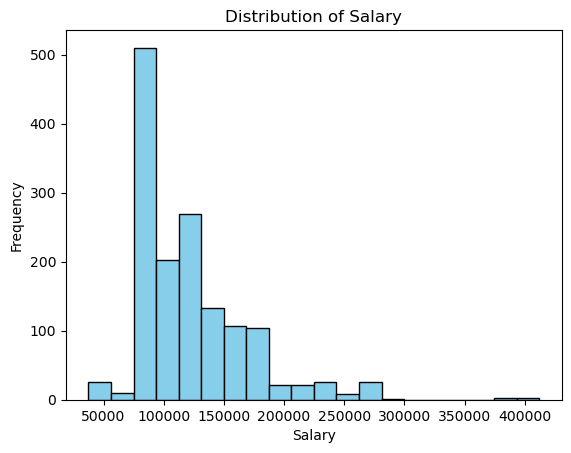

Rows with salary greater than 390000:
                                                  Title  \
1301                          Technical Product Manager   
1351  Technical Director, Machine Learning (Individu...   

                                            Description Company Name  \
1301  Technical Product Manager We could collect fee...    Anthropic   
1351  Technical Director, Machine Learning (Individu...       Roblox   

               City     State  Salary    Year  Month   Day  CS_keywords  
1301  San Francisco  CA 94111  410000  2019.0    9.0  16.0            0  
1351      San Mateo  CA 94401  412050  2019.0    9.0  16.0            1  
Rows with salary lower than 40000:


,Title,Description,Company Name,City,State,Salary,Year,Month,Day,CS_keywords
1251,AI Training for Ukrainian Writers,AI Training for Ukrainian Writers Work on vari...,Scale AI,Remote in New York,NY,37440,2019.0,9.0,16.0,0
1364,AI Training for Greek Writers,AI Training for Greek Writers Work on various ...,Scale AI,Remote in San Francisco,CA,38376,2019.0,9.0,16.0,0


In [16]:
# Plot the histogram of the 'Salary' column
plt.hist(big_merged_df['Salary'], bins=20, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Salary')
plt.ylabel('Frequency')
plt.title('Distribution of Salary')

# Show the plot
plt.show()

# Assuming big_merged_df is your DataFrame

# Filter the DataFrame for rows with salary > 390000
high_salary_rows = big_merged_df[big_merged_df['Salary'] > 390000]
low_salary_rows = big_merged_df[big_merged_df['Salary'] < 40000]

# Print the rows with salary > 390000
print("Rows with salary greater than 390000:")
print(high_salary_rows)
print("Rows with salary lower than 40000:")
low_salary_rows

In [17]:
big_merged_df = big_merged_df[(big_merged_df['State'] != 'United States') & (big_merged_df['State'] != 'Switzerland')]
big_merged_df.shape
state_mapping = {
    'NY': 'New York', 'NC': 'North Carolina', 'MA': 'Massachusetts', 'IL': 'Illinois',
    'NJ': 'New Jersey', 'CA': 'California', 'UT': 'Utah', 'VA': 'Virginia', 'PA': 'Pennsylvania',
    'TX': 'Texas', 'OH': 'Ohio', 'WA': 'Washington', 'DC': 'District of Columbia', 'MO': 'Missouri',
    'WI': 'Wisconsin', 'CO': 'Colorado', 'FL': 'Florida', 'OR': 'Oregon', 'MN': 'Minnesota',
    'GA': 'Georgia', 'MD': 'Maryland', 'TN': 'Tennessee', 'ID': 'Idaho', 'AL': 'Alabama',
    'AZ': 'Arizona', 'CT': 'Connecticut', 'MI': 'Michigan', 'DE': 'Delaware', 'KY': 'Kentucky',
    'NH': 'New Hampshire', 'AR': 'Arkansas', 'SC': 'South Carolina', 'RI': 'Rhode Island',
    'NE': 'Nebraska', 'KS': 'Kansas', 'LA': 'Louisiana', 'IN': 'Indiana', 'MS': 'Mississippi',
    'IA': 'Iowa', 'OK': 'Oklahoma', 'WV': 'West Virginia', 'MH': 'Marshall Islands', 'tx': 'Texas',
    'Tennessee': 'Tennessee', 'California': 'California', 'Illinois': 'Illinois', 'Colorado': 'Colorado',
    'North Carolina': 'North Carolina', 'Anne Arundel': 'Maryland', 'New Jersey': 'New Jersey', 
    'NY 10019': 'New York', 'NY 11238': 'New York', 'NY 10041': 'New York', 'NY 11211': 'New York', 'NY 10001': 'New York', 
    'NY 13731': 'New York', 'NY 10003': 'New York', 'NY 10012': 'New York', 'NY 10010': 'New York', 'NY 10022': 'New York', 
    'NY 10016': 'New York', 'NY 10014': 'New York', 'CA 90291': 'California', 'CA 94107': 'California', 'CA 94025': 'California', 
    'CA 94550': 'California', 'CA 95110': 'California', 'CA 94306': 'California', 'CA 92129': 'California', 'CA 94111': 'California', 
    'CA 90024': 'California', 'CA 94022': 'California', 'CA 94105': 'California','CA 91362': 'California', 'CA 94103': 'California',  
    'CA 90245': 'California', 'CA 94401': 'California', 'CA 95054': 'California', 'CA 95131': 'California', 'CA 92868': 'California', 
    'CA 91423': 'California', 'CA 90017': 'California', 'CA 94063': 'California', 'CA 92821': 'California', 'IL 60607': 'Illinois', 
    'IL 60614': 'Illinois', 'IL 60563': 'Illinois', 'CA 94043': 'California','CA 94304': 'California','CA 94104': 'California',
    'CA 94080': 'California',
}
big_merged_df['State'] = big_merged_df['State'].replace(state_mapping)

## Push the Merged Dataframe to AWS

In [18]:
import io

# Specify the new file key for the LinkedIn data
output_file_key = 'merged_dataset.csv'

# Save the LinkedIn DataFrame to a CSV file in memory
csv_buffer = io.StringIO()
big_merged_df.to_csv(csv_buffer, index=False)

# Upload the CSV file in memory to the S3 bucket
s3.put_object(Body=csv_buffer.getvalue(), Bucket=bucket_name, Key=output_file_key)

{'ResponseMetadata': {'RequestId': 'GBQCZFGG4GF1TWF3',
  'HostId': 'XLchx7vysXJNB4fAIr1+nReLpYStDFPvaZDLutgQUwe+RdPr+sIOj3EzKvz+g3mVP1COQYUDCGs=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'XLchx7vysXJNB4fAIr1+nReLpYStDFPvaZDLutgQUwe+RdPr+sIOj3EzKvz+g3mVP1COQYUDCGs=',
   'x-amz-request-id': 'GBQCZFGG4GF1TWF3',
   'date': 'Fri, 19 Apr 2024 18:50:46 GMT',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"a9b1536d504ac089172552ec07472286"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"a9b1536d504ac089172552ec07472286"',
 'ServerSideEncryption': 'AES256'}